# Visualising the groups from XMM observations

We now use the XMM observations that we have processed to create basic visualisations of the quasars in this study.

## Import statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch, MinMaxInterval
from astropy.convolution import convolve, Gaussian2DKernel
import os
from shutil import rmtree
from legacystamps import download as ls_download
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 10
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/visualisation/')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import BaseSample
from xga.sas import emosaic
from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix

%matplotlib inline

## Defining useful functions

Here we set up any functions that we wish to use in this notebook:

In [2]:
def setup_ims(src, rt, side_length, src_ra, src_dec):
    side_ang_length = src.convert_radius(side_length, 'deg')
    
    j_out_path = save_path + '/' + src.name + "_{sl}kpc_{f}.jpeg".format(sl=side_length.value, f=filters)
    if not os.path.exists(j_out_path):
        down_path = ls_download(src_ra, src_dec, filters, side_ang_length.value, 'jpeg', 
                                pixscale=pix_scale.value, 
                                ddir=save_path)
        os.rename(down_path, j_out_path)        


    out_path = save_path + '/' + src.name + "_{sl}kpc_{f}.fits".format(sl=side_length.value, f=filters)
    if not os.path.exists(out_path):
        down_path = ls_download(src_ra, src_dec, filters, side_ang_length.value, 'fits', 
                                pixscale=pix_scale.value, 
                                ddir=save_path)
        os.rename(down_path, out_path)   

    g_im = Image(out_path, '', 'G', '', '', '', Quantity(0, 'keV'), Quantity(1, 'keV'))

    fits_file = fits.open(out_path)

    hdr = fits_file[0].header
    w = WCS(naxis=2)
    key = ''
    w.wcs.crpix = [hdr["CRPIX1{}".format(key)], hdr["CRPIX2{}".format(key)]]
    w.wcs.cdelt = [hdr["CD1_1{}".format(key)], hdr["CD2_2{}".format(key)]]
    w.wcs.crval = [hdr["CRVAL1{}".format(key)], hdr["CRVAL2{}".format(key)]]
    w.wcs.ctype = [hdr["CTYPE1{}".format(key)], hdr["CTYPE2{}".format(key)]]
    g_im._data = fits_file[0].data[2, :, :]
    g_im._shape = g_im.data.shape
    g_im._header = hdr
    g_im._wcs_radec = w

    grid = np.meshgrid(np.arange(0, g_im.shape[0]), np.arange(0, g_im.shape[1]))
    pix_coords = Quantity(np.stack([grid[0].ravel(), grid[1].ravel()]).T, 'pix')
    deg_coords = g_im.coord_conv(pix_coords, 'deg')
    xmm_pix_coord = rt.coord_conv(deg_coords, 'pix').value

    rates = rt.data[xmm_pix_coord[:, 1], xmm_pix_coord[:, 0]]
    resamp_xray = rates.reshape(g_im.shape)
    smth_resamp_xray = convolve(resamp_xray, Gaussian2DKernel(x_smth_std, x_smth_std))
    
    return plt.imread(j_out_path), smth_resamp_xray

## Reading the sample file

This sample file is required again so that we know the central coordinates and redshifts of the groups.

In [3]:
samp = pd.read_csv('../../sample_files/quasar_info.csv')
samp

name       ra     dec  redshift
0       B1612+266  243.544  26.547     0.395
1   FBQS1519+2838  229.901  28.641     0.270
2     SBS0956+509  149.882  50.747     0.143
3          RBS711  129.245  44.434     0.255
4  FBQSJ1030+3102  157.746  31.049     0.178
5         PHL1811  328.756  -9.373     0.201

## Declaring an XGA sample

A BaseSample object is declared, rather than an ExtendedSample or a ClusterSample, because initially we do not want any automated region matching to take place. This sample will not match to region files, but we can still use it to create images on which regions can be overlaid:

In [4]:
srcs = BaseSample(samp['ra'].values, samp['dec'].values, samp['redshift'].values, samp['name'].values)

Declaring BaseSource Sample: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


## Looking at the information available for each quasar

We can cycle through the sources declared as a part of our sample, and summarise the available XMM observations and information that we currently have available. There is precious little of it! 

In [5]:
for src in srcs:
    src.info()
    print(src.instruments, '\n')


-----------------------------------------------------
Source Name - B1612+266
User Coordinates - (243.544, 26.547) degrees
nH - 0.0299 1e+22 / cm2
Redshift - 0.395
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 1
With regions - 1
Total regions - 72
Obs with 1 detection - 1
Obs with >1 matches - 0
Total exposure - 40.18 ks
Images associated - 9
Exposure maps associated - 6
Combined Ratemaps associated - 2
Spectra associated - 0
-----------------------------------------------------

{'0900700101': ['pn', 'mos1', 'mos2']} 


-----------------------------------------------------
Source Name - FBQS1519+2838
User Coordinates - (229.901, 28.641) degrees
nH - 0.023 1e+22 / cm2
Redshift - 0.27
XMM ObsIDs - 2
PN Observations - 2
MOS1 Observations - 2
MOS2 Observations - 2
On-Axis - 0
With regions - 2
Total regions - 81
Obs with 1 detection - 0
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 12
Combined Ratemaps associated - 0
S

## Generate combined ratemaps

If a 'proper' PointSample had been declared, this process would have been run automatically, but in this case we manually generate combined 0.5-2.0 keV ratemaps by calling emosaic (with the default `lo_en=Quantity(0.5, 'keV')` and `hi_en=Quantity(2.0, 'keV')` values) separately for images and exposure maps. The count-rate maps are created automatically when a matching pair of image and exposure map are detected: 

In [6]:
emosaic(srcs, 'image')
emosaic(srcs, 'expmap')

Generating products of type(s) expmap: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


## View XMM visualisations of the quasars

Two ratemap visualisations are created for each group, one with the full combined field of view of the available XMM observations, and one zoomed in to an aperture with radius 500 kpc. The XCS detection regions are overlaid on both:

B1612+266


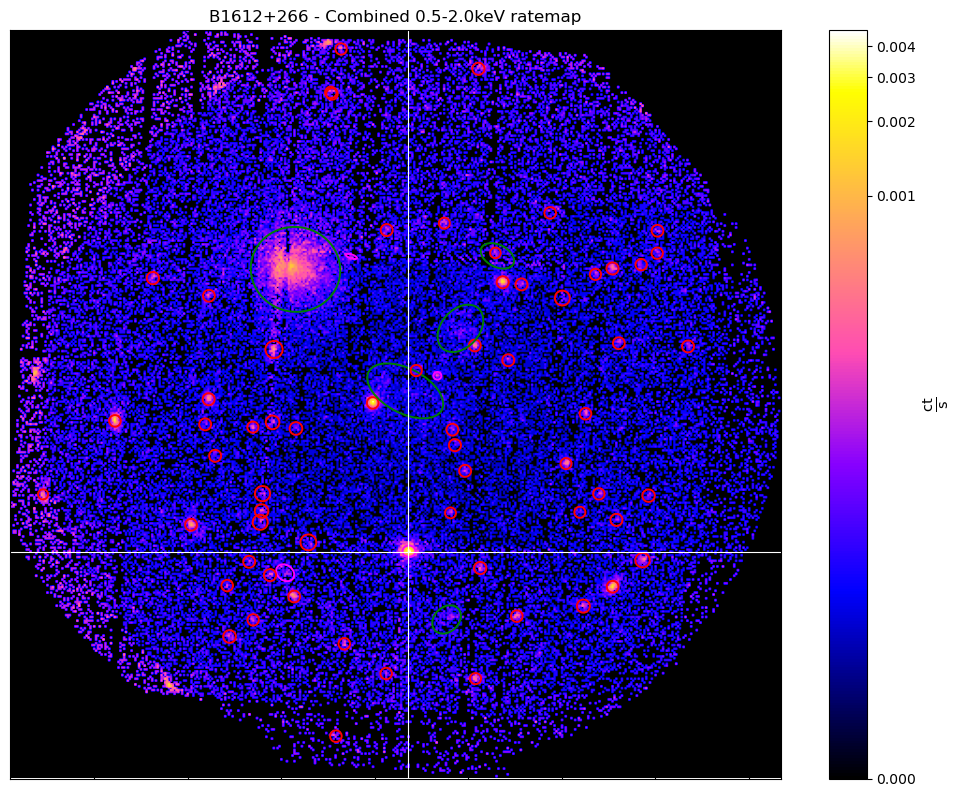

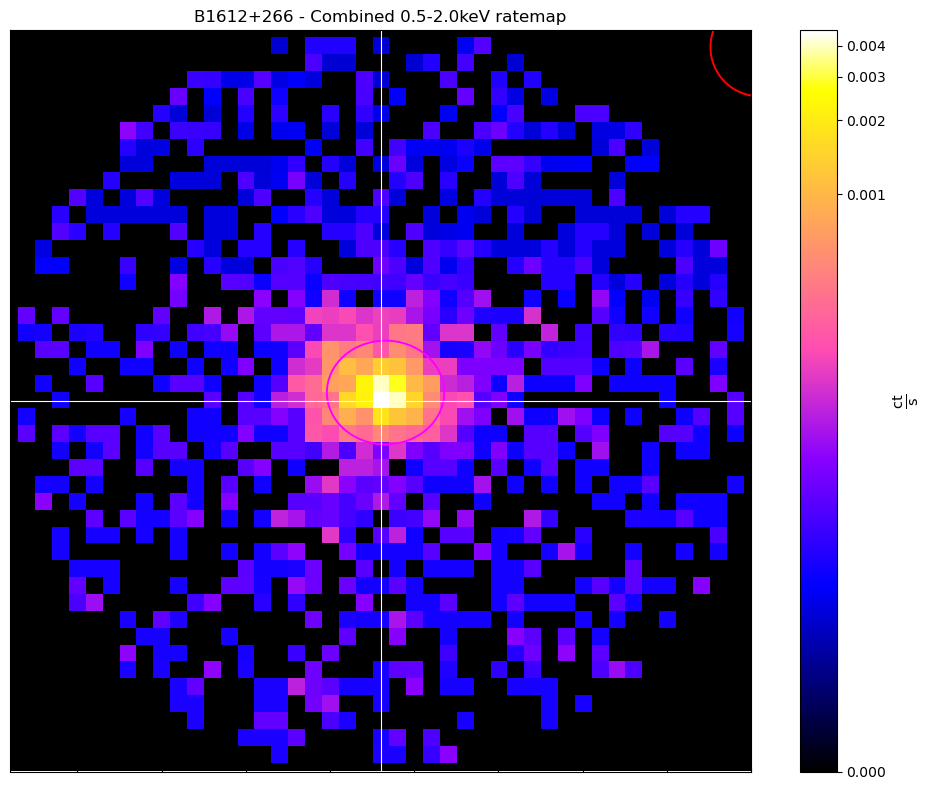

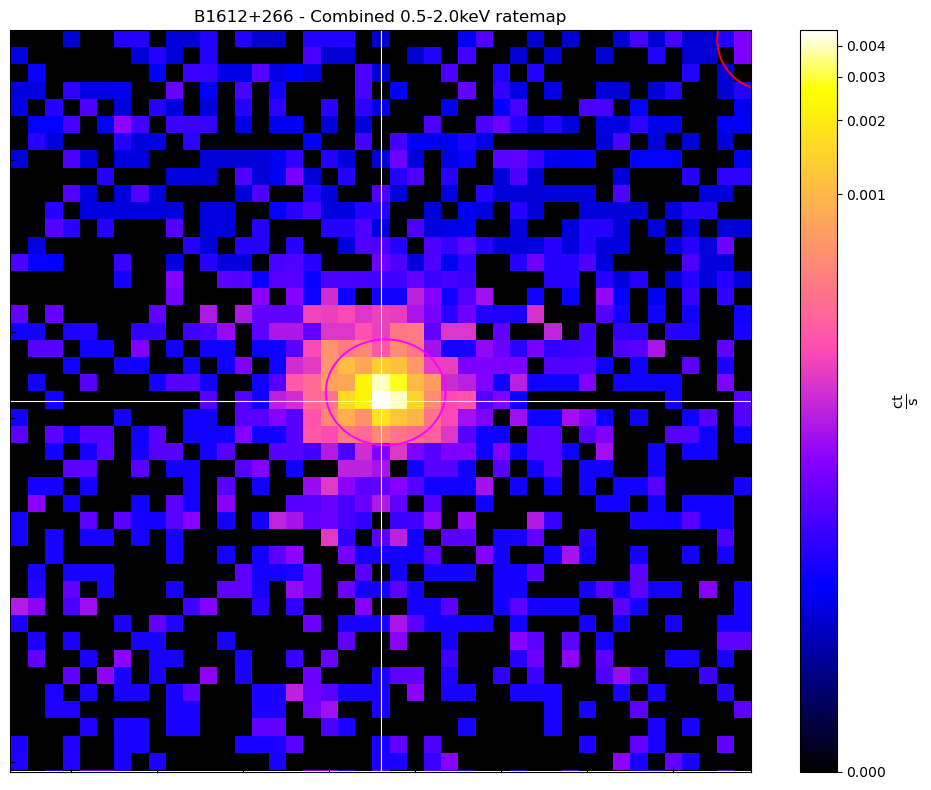





FBQS1519+2838


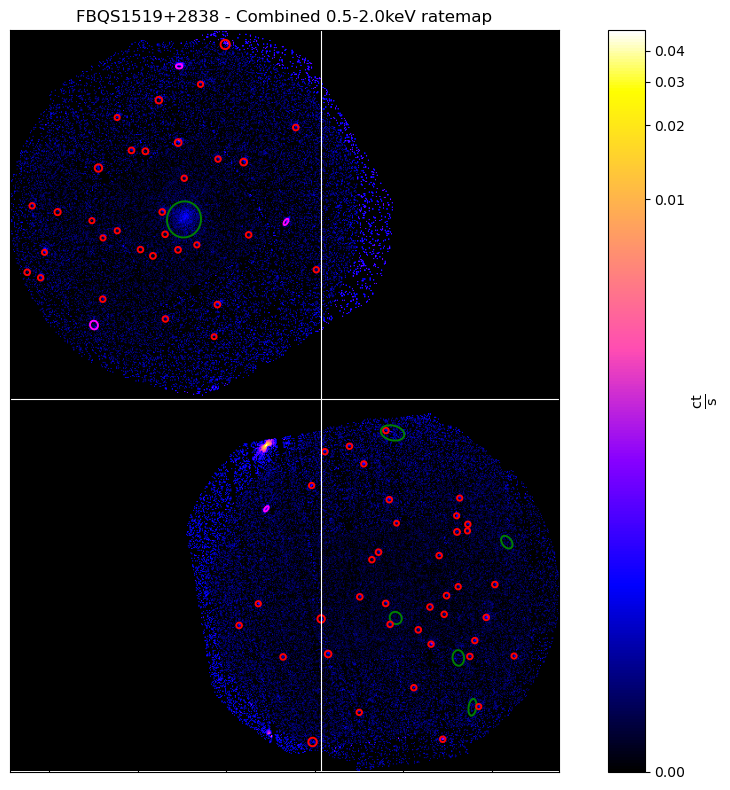





SBS0956+509


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: divide by zero encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


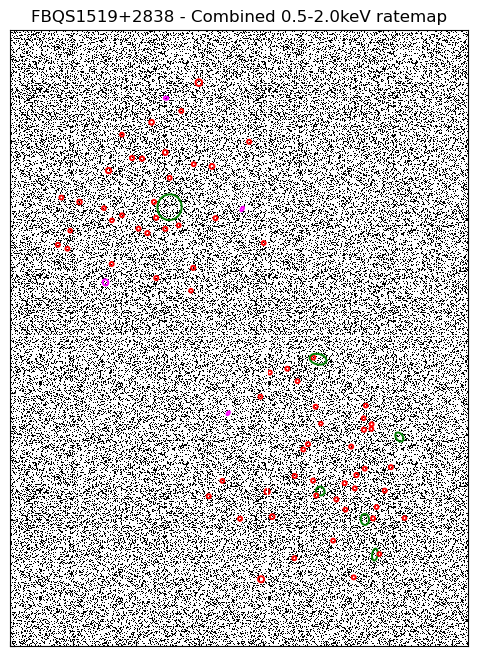

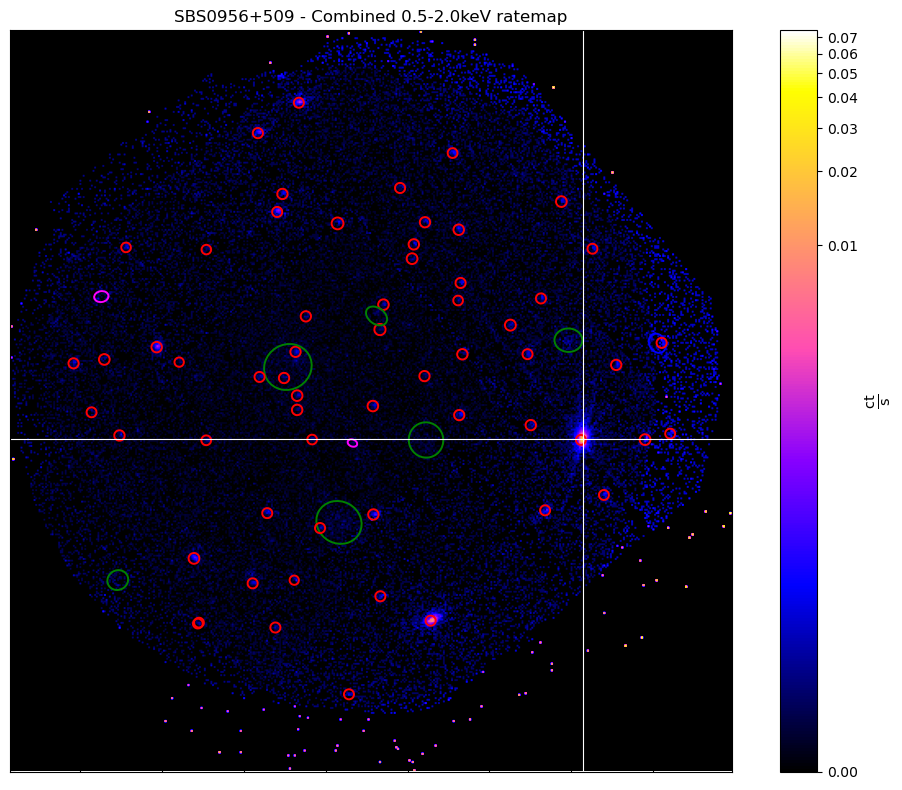

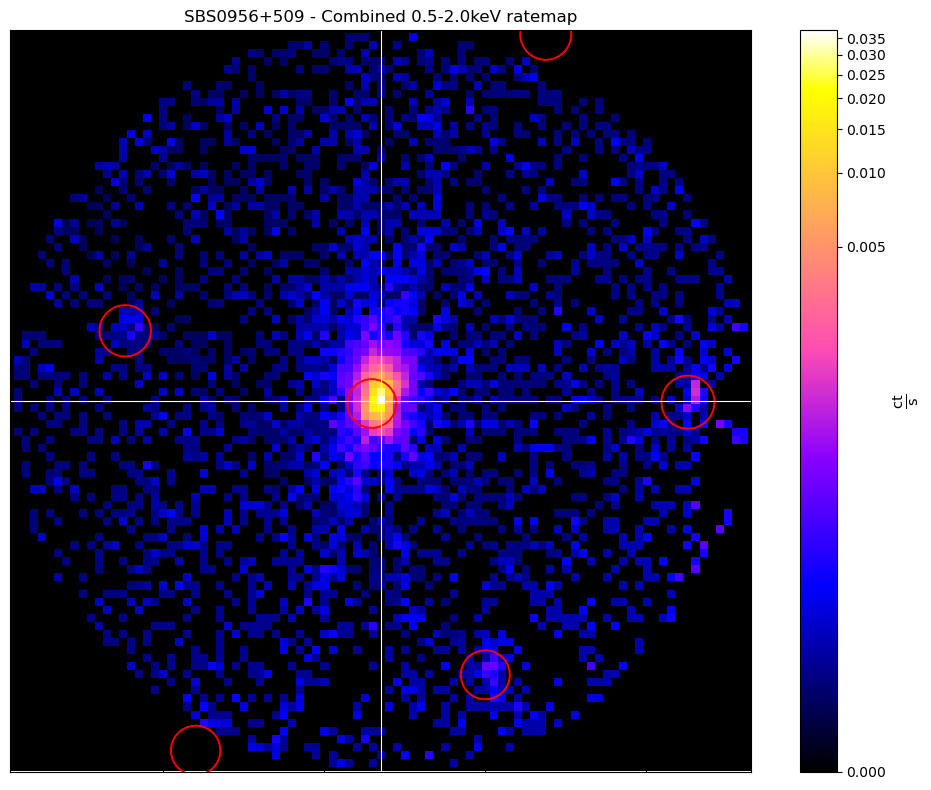

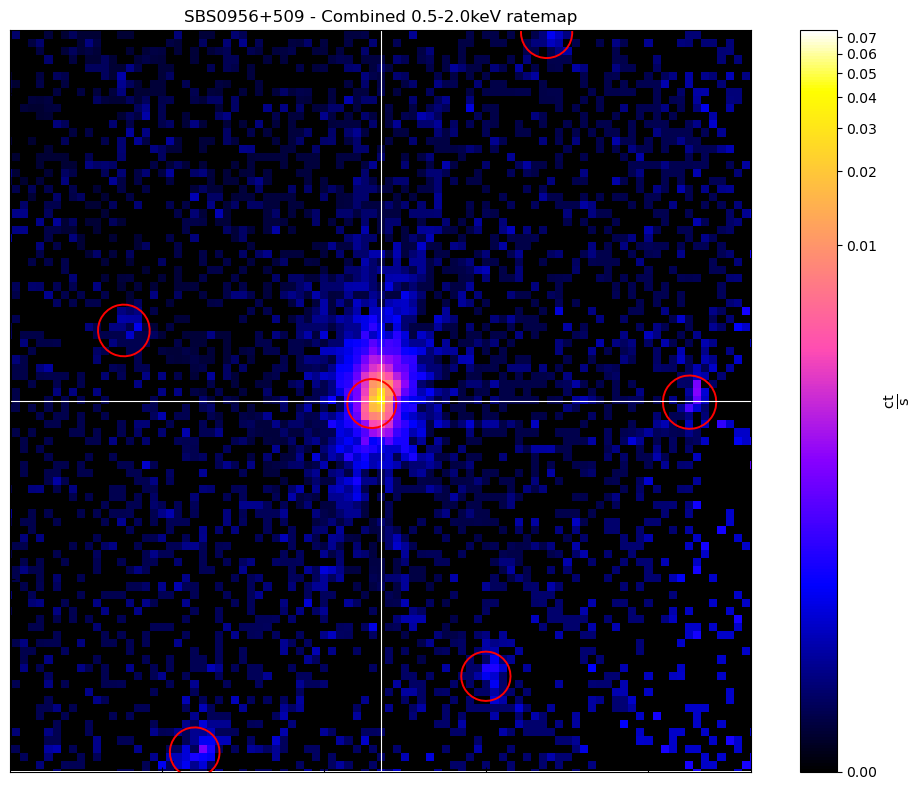





RBS711


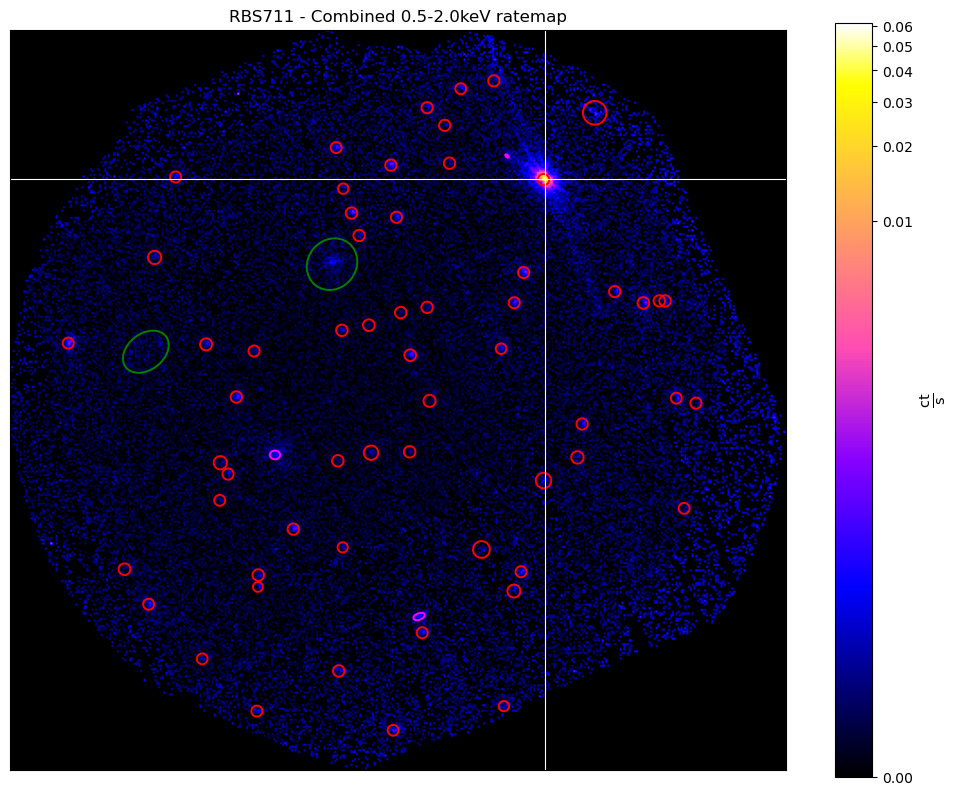

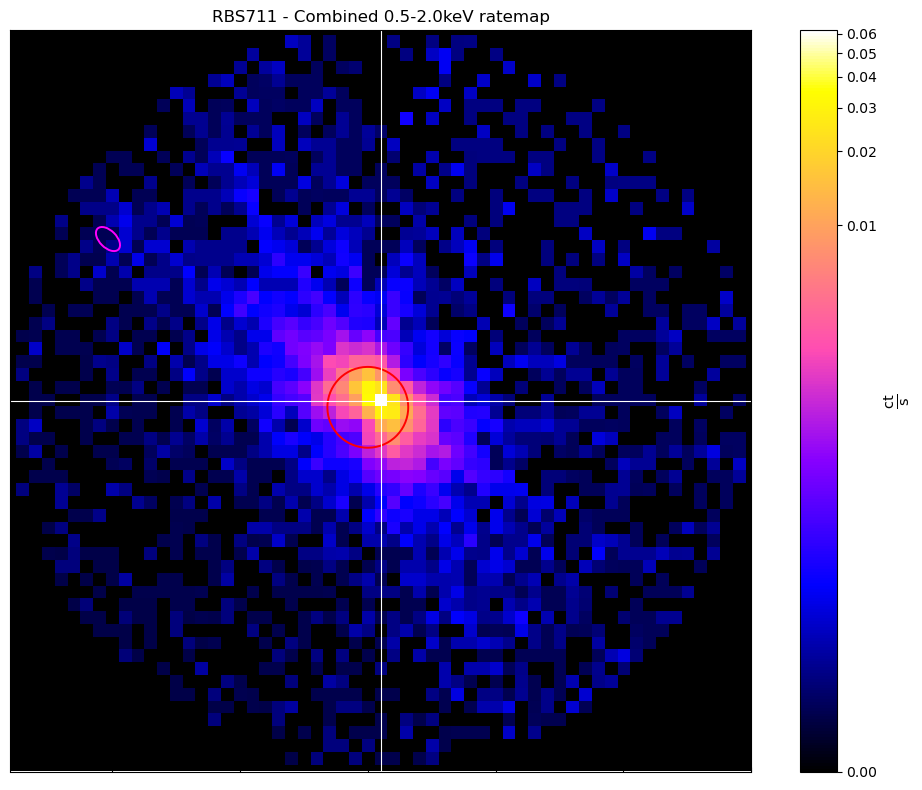

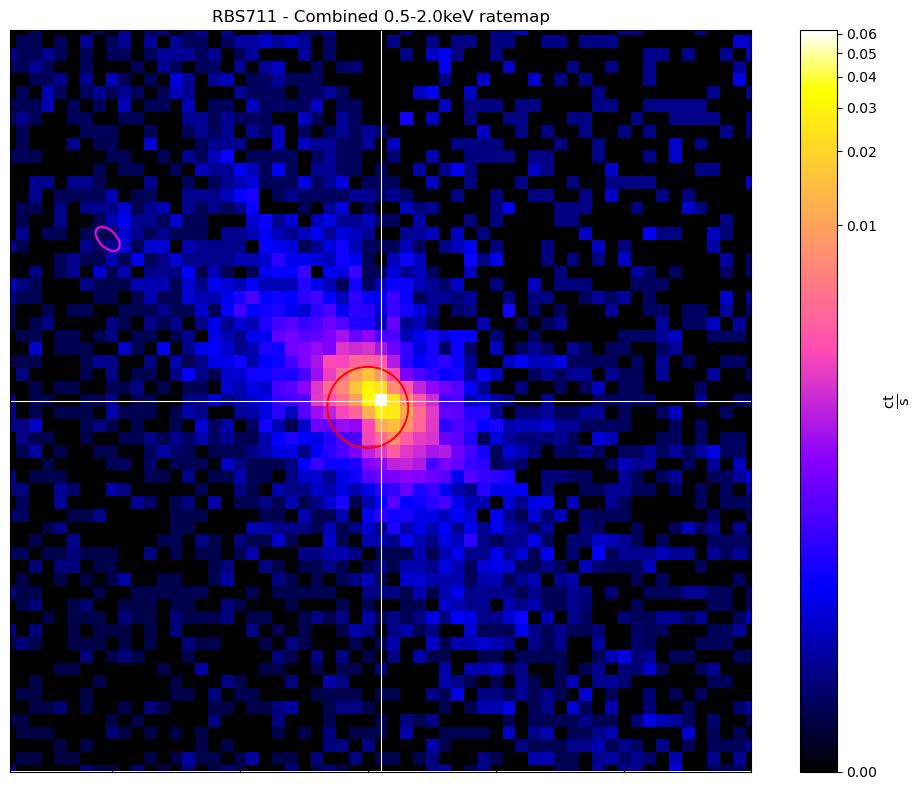





FBQSJ1030+3102


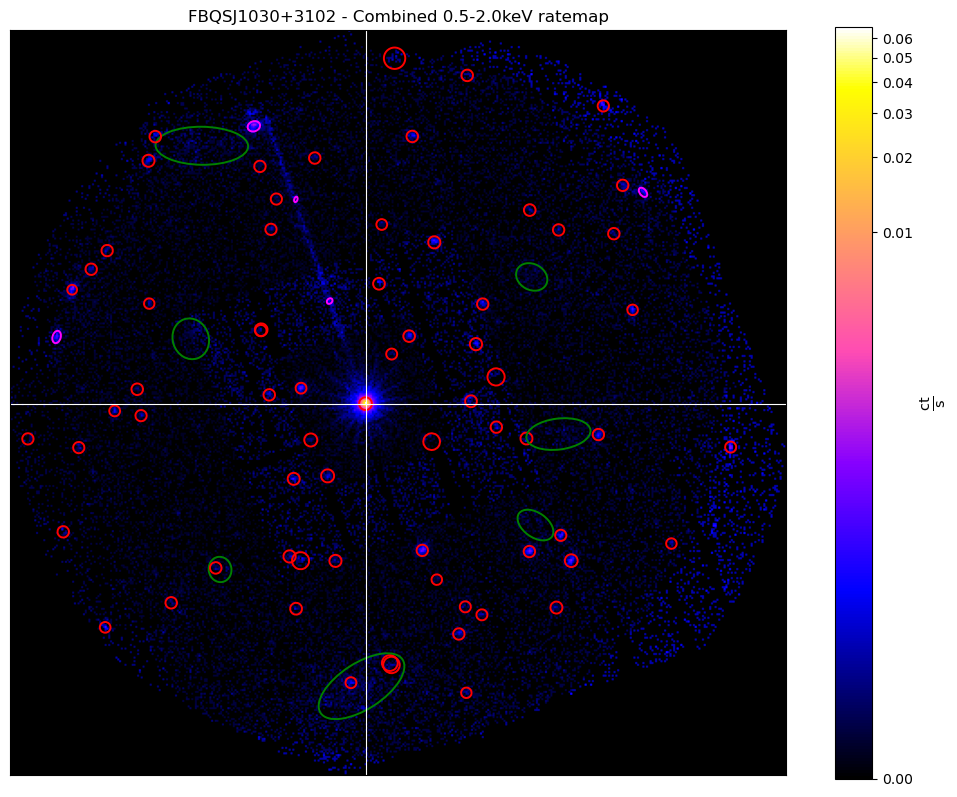

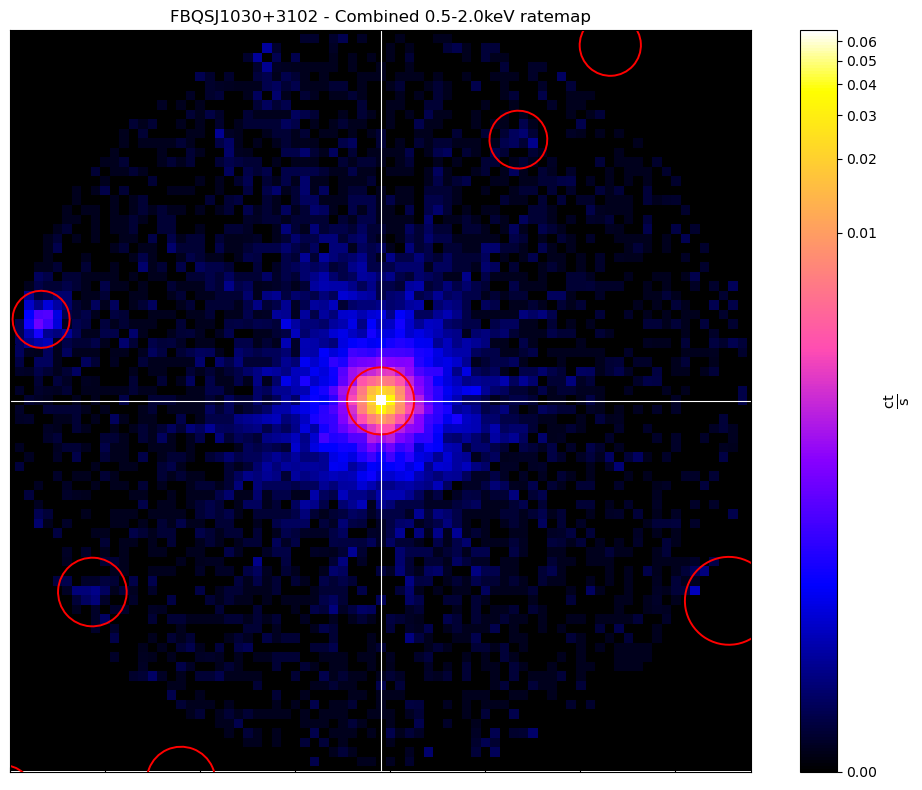

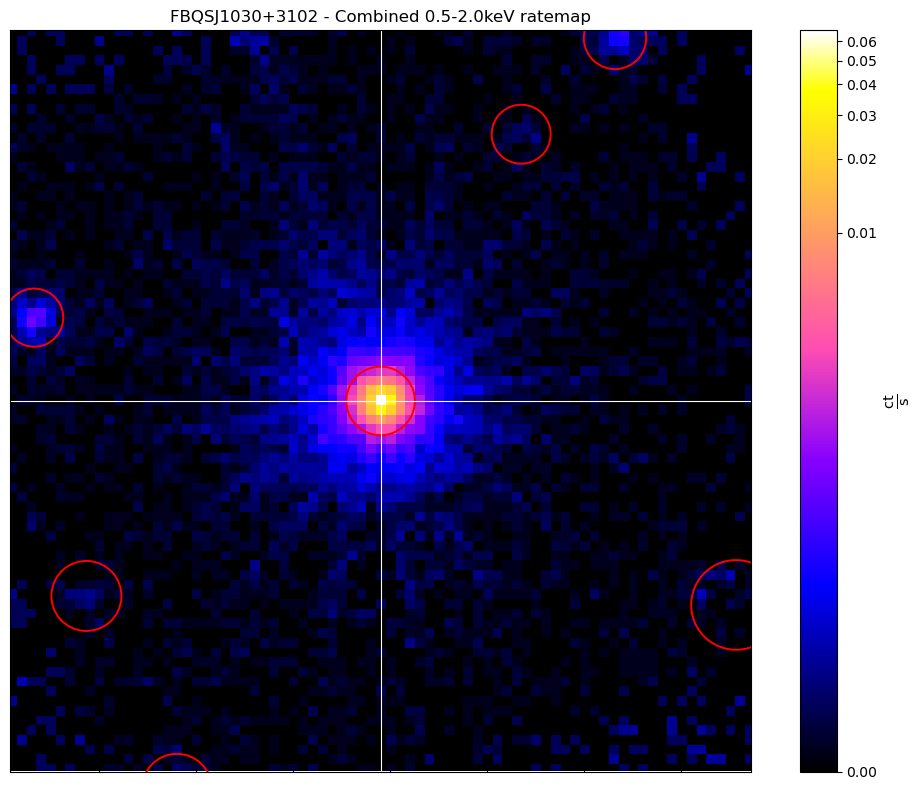





PHL1811


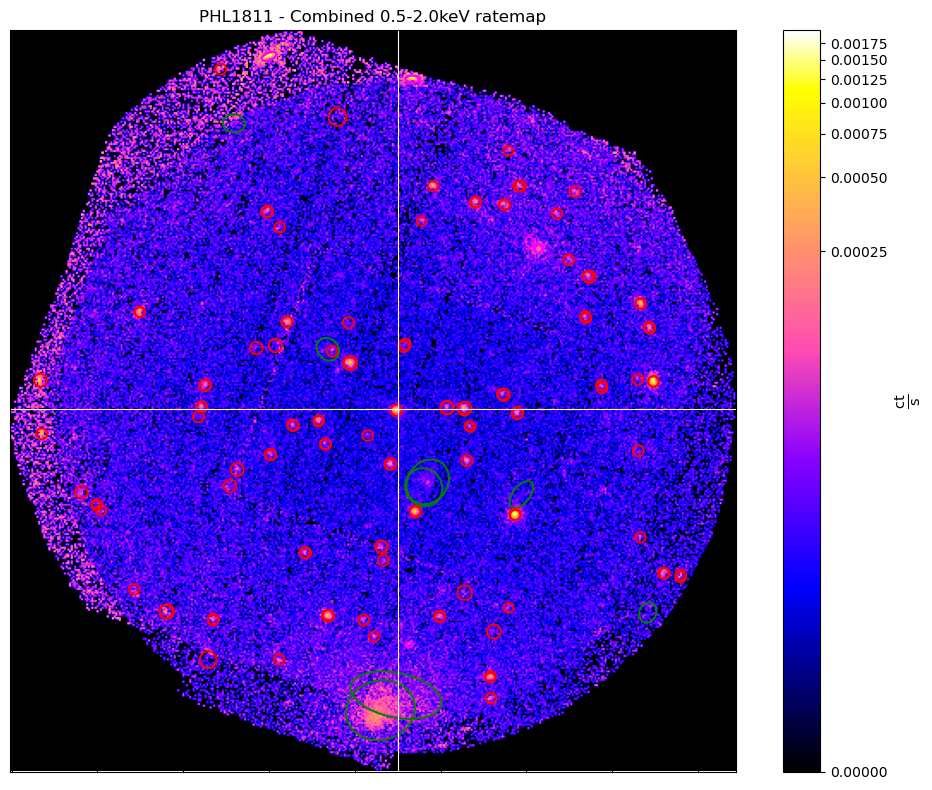

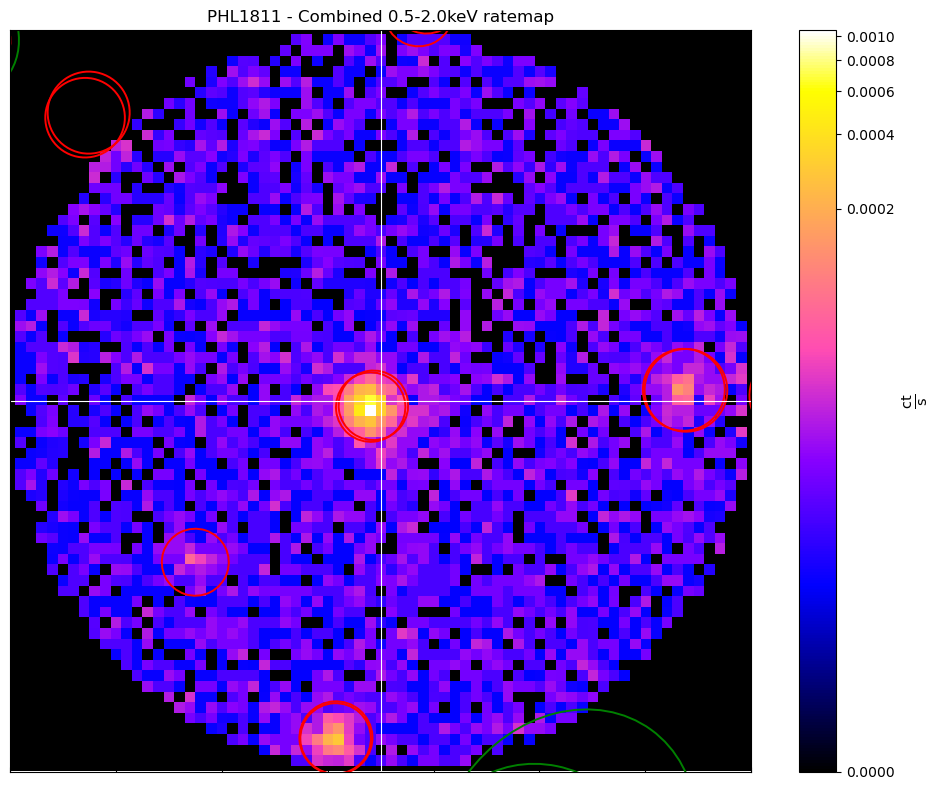

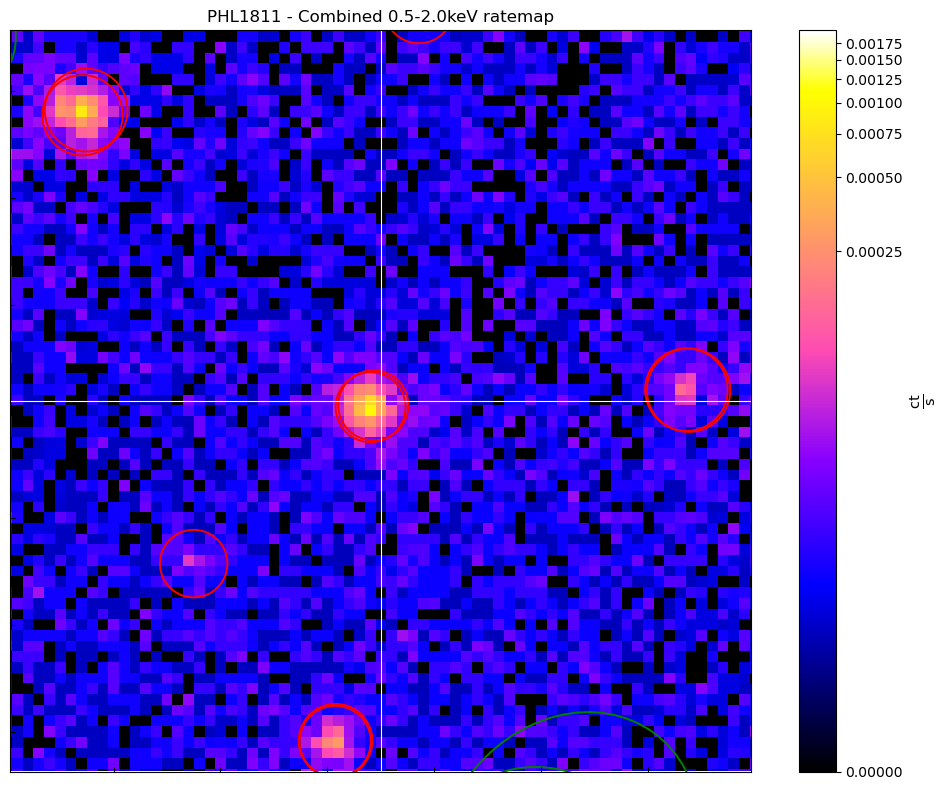

In [8]:
for src in srcs:
    print(src.name)
    rt = src.get_combined_ratemaps()
    
    if any([len(r) != 1 for o, r in src._initial_regions.items()]):
        rt.regions = src._initial_regions
    rt.view(src.ra_dec, zoom_in=True, view_regions=True)
    try:
        rt.view(src.ra_dec, src.get_custom_mask(Quantity(500, 'kpc'), remove_interlopers=False), view_regions=True, 
                zoom_in=True)

        pix_rad = physical_rad_to_pix(rt, Quantity(500, 'kpc'), src.ra_dec, src.redshift, src.cosmo)
        pix_cen = rt.coord_conv(src.ra_dec, 'pix')
        x_lims = [(pix_cen[0]-pix_rad).value, (pix_cen[0]+pix_rad).value]
        y_lims = [(pix_cen[1]-pix_rad).value, (pix_cen[1]+pix_rad).value]
        rt.view(src.ra_dec, view_regions=True, zoom_in=True, manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)

    #     # As well as displaying them in the notebook, as above, we save these figures
    #     rt.save_view('../../outputs/figures/xray_ims/{n}_XMM52_FoV.png'.format(n=src.name), src.ra_dec, 
    #                  zoom_in=True, view_regions=True)
    #     # The mask is a 500kpc radius, so sidelength is 1000kpc
    #     rt.save_view('../../outputs/figures/xray_ims/{n}_XMM52_1000kpc_.png'.format(n=src.name), src.ra_dec, 
    #                  src.get_custom_mask(Quantity(500, 'kpc'), remove_interlopers=False), view_regions=True, 
    #             zoom_in=True)
    except ValueError:
        pass
    
    print('\n\n\n')

## Legacy Survey DR9 & XMM images

We can use the Legacy Survey cutout service to grab grz images, both jpeg and FITS, for our objects. The size and centering of the images are directly controllable. The initial intention was to make our own colour images from the grz FITS images, but we could not make them look as nice as those on the platform, so only the WCS information from the FITS files was used.

A small module called legacy-stamps was used to interact with the Legacy Survey cutout URLs.

### Setup and configuration

Here we can set various variables to alter the images we generate, and also setup a new colormap for the X-ray images:

In [ ]:
# This ensures that the path we wish to save downloaded LS-DR9 images in exists
save_path = os.path.abspath("../../outputs/ls_images")
if not os.path.exists(save_path):
    os.makedirs(save_path)

# The side length of the images we want to make
side_length = Quantity(1200, 'kpc')
# The pixel scale we are requesting from the LS cutout server - this is the default
pix_scale = Quantity(0.262, 'arcsec/pix')

# This doesn't actually seem to do anything, it always returns grz - that may be all that is available
#  for DR9
filters = 'grz'

# The smoothing standard deviation for the X-ray images
x_smth_std = 20

We truncate the gnuplot2 colormap, for use in overplotting the X-ray emission. We tried this because the upper colours of the gnuplot2 colormap are very similar to the colours of the galaxies in our groups:

In [ ]:
cmap = matplotlib.colormaps['gnuplot2']

upper_color = 0.7
lower_color = 0
num_colors =  20 

new_cmap = LinearSegmentedColormap.from_list('trunc_gnu2', 
                                             cmap(np.linspace(lower_color, upper_color, num_colors)), 
                                             N=num_colors)
new_cmap_r = LinearSegmentedColormap.from_list('trunc_gnu2_r', 
                                               cmap(np.linspace(lower_color, upper_color, num_colors))[::-1], 
                                               N=num_colors)

### Downloading LS-DR9 images and resampling XMM ratemaps

Here we download the LS images that are specified by the central coordinates of our groups, and the side length and pixel scale defined above. As the XMM ratemaps are not going to be the same pixel scale, we will have to resample them to match the LS images, and we will then smooth them to make the final result nicer to look at:

In [ ]:
ls_ims = {}
sm_x_ims = {}

with tqdm(desc='Getting images', total=len(srcs)) as onwards:
    for src in srcs:
        src_ra, src_dec = src.ra_dec.value

        ls_im_arr, smth_x_arr = setup_ims(src, src.get_combined_ratemaps(), side_length, src_ra, src_dec)
        
        ls_ims[src.name] = ls_im_arr
        sm_x_ims[src.name] = smth_x_arr
        
        onwards.update(1)

### Generating LS-DR9 grz + X-ray images

Finally, we create figures that show the optical observations overlaid with smoothed X-ray emission:

In [ ]:
for src in srcs:
    rgb_im = np.flipud(ls_ims[src.name])
    smth_resamp_xray = sm_x_ims[src.name]
    
#     ------------------------------------------------------
    
#     plt.figure(figsize=(8, 8))
#     plt.imshow(rgb_im, origin='lower', alpha=1)
    
#     ax = plt.gca()
#     ax.tick_params(axis='both', direction='in', which='both', top=False, right=False)
#     ax.xaxis.set_ticklabels([])
#     ax.yaxis.set_ticklabels([])

#     scalebar = ScaleBar(pix_scale.value, "''", "angle", length_fraction=0.25, box_alpha=0.6)
#     ax.add_artist(scalebar)

#     plt.title(r'{n} - Legacy Survey DR9 grz'.format(n=src.name))
#     plt.show()
    
#     ------------------------------------------------------
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_im, origin='lower', alpha=1)

    norm = ImageNormalize(smth_resamp_xray, interval=MinMaxInterval(), stretch=LogStretch())
    plt.imshow(smth_resamp_xray, origin='lower', cmap=new_cmap, alpha=0.4, norm=norm)

    ax = plt.gca()
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    scalebar = ScaleBar(pix_scale.value, "''", "angle", length_fraction=0.25, box_alpha=0.6)
    ax.add_artist(scalebar)

    plt.title(r'{n} - Legacy Survey DR9 grz & XMM 0.5-2.0keV'.format(n=src.name))
    plt.tight_layout()
    plt.savefig('../../outputs/figures/opt_xray_ims/{n}_LSDR9grz_XMM52_{l}.png'.format(n=src.name, l=side_length))
    plt.show()
    
    print('\n\n\n')